We will now impleent the temporal GNN

Update and learning structure: Message passing will be applied iterativley to adhere to the flow of conversation and the progress of participant memory. The steps will be as follows:

    For each graph G0 ->....-> Gn ->....
        1. Apply one layer of message passing to update the three nodes in Gn that are being spoken to by the speaker node (blue edges). 
        2. Apply one layer of message passing for each node A(n+1) referencing only their previous state An (updated in (1)) 


We will use GAT as an aggregation method in message passing such that different weights are placed on the extent to which a speaker's embedding defines another nodes embedding. Below is an image of the ways graphs will be structured. 


In [28]:
import pickle

In [29]:
# Load the graphs data from file
with open('../graphs/data/temporal_graphs.pkl', 'rb') as f:
    temporal_graphs = pickle.load(f)

In [30]:
print(temporal_graphs[0])

{'meeting': 'IS1006d', 'start': 1500.0, 'kappa': 0.2982470876861914, 'cohesion_score': 5.197368421052632, 'G': {'A_0': {'embedding': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
def filter_binarize_temporal_graphs(temporal_graphs, kappa, ceiling, floor): 
    filtered_graphs = []
    for g in temporal_graphs: 
        if (g['kappa'] >= kappa):
            if g['cohesion_score'] <= ceiling: 
                g['cohesion_score'] = 0
                filtered_graphs.append(g)
            elif g['cohesion_score'] > floor: 
                g['cohesion_score'] = 1
                filtered_graphs.append(g)


    return filtered_graphs


In [32]:
temporal_graphs = filter_binarize_temporal_graphs(temporal_graphs=temporal_graphs, kappa=0.00, ceiling=3.7, floor=4.6)
print('Number of remaining samples: ', len(temporal_graphs))

Number of remaining samples:  72


below we define a simple dataset to use to build the model. 

In [33]:
import torch
from torch_geometric.data import Data, Dataset

class CohesionGraphDataset(Dataset):
    def __init__(self, data_list, minimum_exchanges=4):
        """
        PyTorch Geometric Dataset for processing temporal graphs with binary labels.

        Parameters:
        - data_list: A list of dictionaries where each entry contains a graph and label.
        """
        super(CohesionGraphDataset, self).__init__()
        self.data_list = []

        for entry in data_list:
            graph_data = entry['G']  # This holds the node embeddings and edges
            node_names = list(graph_data.keys())  

            if len(node_names) >= minimum_exchanges: 

                node_features = []
                edge_index = []

                # Iterate over each node in the graph to collect embeddings and edge info
                for node in node_names:
                    # Get the node embedding and edges
                    node_embedding = graph_data[node]['embedding']
                    edges = graph_data[node]['edges']

                    # Append node embedding
                    node_features.append(node_embedding)

                    # Convert node names into indices and append to edge index
                    src_idx = node_names.index(node)
                    for edge_target in edges:
                        if edge_target in node_names:
                            dst_idx = node_names.index(edge_target)
                            edge_index.append([src_idx, dst_idx])

                # Convert node features and edge indices to tensors
                x = torch.tensor(node_features, dtype=torch.float)
                edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

                # Store the binary label as the y label
                y = torch.tensor([entry['cohesion_score']], dtype=torch.float)

                # Create Geometric Data object with node names as an additional attribute
                data = Data(x=x, edge_index=edge_index, y=y)
                data.node_names = node_names  # Store node names in the Data object

                self.data_list.append(data)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]



In [34]:
import torch
from torch_geometric.data import Data

def get_subgraph_for_timestamp(graph, timestamp):
    """
    Returns a PyTorch Geometric Data object representing the subgraph
    (G_n and G_n-1) for a specific timestamp.

    """
    # Isolate nodes in G_n and G_n-1 using the node_names attribute
    nodes_in_Gn = [i for i, name in enumerate(graph.node_names) if name.split('_')[1] == str(timestamp)]
    nodes_in_Gn_1 = [i for i, name in enumerate(graph.node_names) if name.split('_')[1] == str(timestamp - 1)]

    # Combine nodes from G_n and G_n-1
    nodes_in_relevant_subgraph = nodes_in_Gn + nodes_in_Gn_1

    # Create a mapping from global indices (in the full graph) to local indices (in the subgraph)
    global_to_local = {global_idx: local_idx for local_idx, global_idx in enumerate(nodes_in_relevant_subgraph)}

    # Isolate edges that point to nodes in G_n from nodes in G_n-1 or within G_n
    edges_in_timestamp = [edge for edge in graph.edge_index.t().tolist()
                          if edge[1] in nodes_in_Gn and edge[0] in nodes_in_relevant_subgraph]

    # Remap the edge indices to be relative to the subgraph's node indices
    edge_index = torch.tensor([[global_to_local[edge[0]], global_to_local[edge[1]]] for edge in edges_in_timestamp], dtype=torch.long).t().contiguous()

    # Extract the node features (embeddings) for the relevant nodes
    node_features = graph.x[nodes_in_relevant_subgraph]

    # Create and return a PyTorch Geometric Data object for the subgraph
    subgraph = Data(x=node_features, edge_index=edge_index)

    return subgraph



In [35]:
from torch.utils.data import random_split

# create dataset and split using stratified sampling
dataset = CohesionGraphDataset(temporal_graphs)

# Assuming `dataset` is your full dataset (a list of Data objects)
total_size = len(dataset)
test_size = int(0.2 * total_size)  # 20% for testing
train_val_size = total_size - test_size  # 80% for training and validation

# Create a random split for training_val and test sets
data_train_val, data_test = random_split(dataset, [train_val_size, test_size])

print(f'Size of training/validation set: {len(data_train_val)}')
print(f'Size of testing set: {len(data_test)}')


Size of training/validation set: 57
Size of testing set: 14


lets now implement the model architecture 

In [36]:
hyperparams = {
    'batch_size' : 4, 
    'save_loss_interval' : 10, 
    'print_interval' : 50,
    'n_epochs' : 500, 
    'learning_rate' : 0.01,
    'hidden_size':768, 
    'dropout_rate': 0.3
}

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention

class SequentialTGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SequentialTGNN, self).__init__()
        
        # Define GAT layers for message passing
        self.gat_conv = GATConv(input_dim, hidden_dim)  # Single GAT layer to perform message passing
        
        # Define the attention mechanism for pooling
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.global_att_pool = GlobalAttention(self.attention_layer)

        # Output layer for classification
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, graph):
        """
        Forward pass through the model, iterating over all subgraphs (timestamps).
        """
        total_timestamps = graph.x.size(0) // 4  # Assuming 4 nodes per timestamp

        # Initialize a new tensor to store updated node embeddings
        updated_graph_x = graph.x.clone()  # Clone the original node features to avoid in-place modifications

        # Process each subgraph (Gn and Gn-1) sequentially
        for timestamp in range(total_timestamps):
            # Get the subgraph for the current timestamp (returns a Data object)
            subgraph = get_subgraph_for_timestamp(graph, timestamp)

            # Perform message passing for this subgraph
            node_embeddings = self.gat_conv(subgraph.x, subgraph.edge_index)  # Message passing
            node_embeddings = F.relu(node_embeddings)

            # Update the node embeddings in the cloned tensor
            nodes_to_update = torch.arange(subgraph.x.size(0))
            updated_graph_x[nodes_to_update] = node_embeddings

        # Apply global pooling over the updated graph
        pooled_embedding = self.global_att_pool(updated_graph_x, torch.zeros(updated_graph_x.size(0), dtype=torch.long))

        # Output layer (e.g., binary classification)
        output = self.output_layer(pooled_embedding)

        # Apply sigmoid to ensure output is between 0 and 1
        output = torch.sigmoid(output)

        return output






In [38]:
import torch
from torch_geometric.data import DataLoader  
from torch.utils.data import Subset
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.model_selection import KFold
import os

def train_k_fold(dataset, hyperparams, k=5, patience=10, model_save_path='models'):
    """
    Train a model using K-fold cross-validation and save each model for each fold.

    Parameters:
    - model_class: The class of the model to instantiate for each fold.
    - dataset: The dataset of graphs and labels.
    - hyperparams: Dictionary containing hyperparameters for the training process.
    - k: Number of folds for cross-validation.
    - patience: Number of epochs to wait without improvement before stopping early.
    - model_save_path: Path to save models for each fold.

    Returns:
    - A list of training losses for each fold.
    """
    # Create folder to save models if it doesn't exist
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    # KFold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_losses = []  # Store losses for each fold

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("=================================================================================")
        print(f"Training fold {fold + 1}/{k}")

        # Create train and validation datasets for this fold
        train_data = Subset(dataset, train_idx)
        val_data = Subset(dataset, val_idx)
        # Initialize model for each fold
        model = SequentialTGNN(input_dim=768, hidden_dim=hyperparams['hidden_size'], output_dim=1)  

        # Initialize DataLoaders for training and validation data
        train_loader = DataLoader(train_data, batch_size=hyperparams['batch_size'], shuffle=True)
        val_loader = DataLoader(val_data, batch_size=hyperparams['batch_size'], shuffle=False)

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
        criterion = nn.BCELoss()  # Assuming binary classification (adjust as necessary)

        # Track training loss for this fold
        training_losses = []
        validation_losses = []
        best_loss = np.inf  # Initialize to infinity
        epochs_without_improvement = 0  # Track how many epochs without improvement

        # Training loop
        for epoch in range(hyperparams['n_epochs']):
            model.train()  # Set model to training mode
            epoch_loss = 0.0  # Accumulate loss for each epoch
            # print("Starting Epoch ", epoch)
            for i, batch in enumerate(train_loader):
                optimizer.zero_grad()  # Clear previous gradients

                # Initialize a list to store outputs for the batch
                batch_outputs = []

                # Iterate over each graph in the batch
                for graph in batch.to_data_list():  # Convert the batch to a list of graphs
                    # Forward pass for each individual graph
                    output = model(graph)  # Pass a single graph to the forward method
                    batch_outputs.append(output)

                # Stack the outputs for all graphs in the batch
                outputs = torch.cat(batch_outputs, dim=0)  # Combine outputs into a single tensor

                # Extract the labels from the batch
                labels = batch.y  # Labels are still batched together
                # print("Finished forward pass for batch ", i)
                # print("outputs: ", outputs.data)
                # print("labels: ", labels )
                # Convert labels to appropriate type and shape
                labels = labels.float().unsqueeze(1)  # Adjusting for binary classification

                # Compute loss
                loss = criterion(outputs, labels)
                loss.backward()  # Backpropagation
                optimizer.step()  # Gradient update

                epoch_loss += loss.item()  # Accumulate loss

            # Calculate average loss for the epoch
            avg_loss = epoch_loss / len(train_loader)
            training_losses.append(avg_loss)

            # Validation step
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():  # Disable gradient calculations for validation
                for val_batch in val_loader:
                    val_outputs = []

                    for graph in val_batch.to_data_list():
                        output = model(graph)
                        val_outputs.append(output)

                    val_outputs = torch.cat(val_outputs, dim=0)
                    val_labels = val_batch.y.float().unsqueeze(1)

                    # Compute validation loss
                    val_loss += criterion(val_outputs, val_labels).item()

            val_loss /= len(val_loader)
            validation_losses.append(val_loss)

            print(f"Epoch [{epoch + 1}], "
                f"Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}")

            # Early Stopping Logic
            if val_loss < best_loss:
                best_loss = val_loss  # Update the best validation loss
                epochs_without_improvement = 0  # Reset the counter if there's an improvement
                # Optionally, save the best model
                best_model_path = os.path.join(model_save_path, f'best_model_fold_{fold + 1}.pt')
                torch.save(model.state_dict(), best_model_path)
            else:
                epochs_without_improvement += 1  # No improvement

            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. No improvement in {patience} epochs for fold {fold + 1}.")
                break  # Stop training if no improvement for 'patience' epochs

        fold_losses.append((training_losses, validation_losses))  # Store training and validation losses for this fold

    return fold_losses


In [39]:
fold_losses = train_k_fold(data_train_val, hyperparams, k=5, patience=3, model_save_path='models')

Training fold 1/5


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1], Training Loss: 0.5764, Validation Loss: 1.0052
Epoch [2], Training Loss: 0.6169, Validation Loss: 0.6786
Epoch [3], Training Loss: 0.6672, Validation Loss: 0.6785
Epoch [4], Training Loss: 0.6537, Validation Loss: 0.6737
Epoch [5], Training Loss: 0.6377, Validation Loss: 0.6699
Epoch [6], Training Loss: 0.6231, Validation Loss: 0.6648
Epoch [7], Training Loss: 0.6356, Validation Loss: 0.6383
Epoch [8], Training Loss: 0.5502, Validation Loss: 0.5988
Epoch [9], Training Loss: 0.5496, Validation Loss: 0.6457
Epoch [10], Training Loss: 0.6112, Validation Loss: 0.6365
Epoch [11], Training Loss: 0.6044, Validation Loss: 0.6410
Early stopping at epoch 11. No improvement in 3 epochs for fold 1.
Training fold 2/5
Epoch [1], Training Loss: 0.5492, Validation Loss: 0.9673
Epoch [2], Training Loss: 0.5663, Validation Loss: 0.6593
Epoch [3], Training Loss: 0.4347, Validation Loss: 0.8394
Epoch [4], Training Loss: 0.4324, Validation Loss: 0.5964
Epoch [5], Training Loss: 0.3072, Validatio

In [40]:
import torch
from torch_geometric.data import DataLoader
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model
def evaluate_model(kmodel, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    kmodel.eval()
    kmodel = kmodel.to(device)
    
    all_probs = []
    all_labels = []

    with torch.no_grad():  
        for data in data_test:
            out = kmodel(data).squeeze(-1)  
            probs = torch.sigmoid(out)  
            all_probs.append(probs.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # compute metrics across all test samples
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

    # Calculate F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Filter out NaN values from F1 scores
    valid_idx = ~np.isnan(f1_scores)
    valid_f1_scores = f1_scores[valid_idx]
    valid_thresholds = thresholds[valid_idx[:-1]]  # thresholds are one element shorter than f1_scores

    # Find the threshold that maximizes the valid F1 score
    optimal_idx = np.argmax(valid_f1_scores)
    optimal_threshold = valid_thresholds[optimal_idx]
    optimal_f1 = valid_f1_scores[optimal_idx]

    # Evaluate the model using the optimal threshold
    preds = (all_probs >= optimal_threshold).astype(int)

    # Now calculate the final evaluation metrics based on this threshold
    accuracy = accuracy_score(all_labels, preds)
    precision_final = precision_score(all_labels, preds, zero_division=0)
    recall_final = recall_score(all_labels, preds, zero_division=0)
    f1_final = f1_score(all_labels, preds, zero_division=0)

    return accuracy, precision_final, recall_final, f1_final, preds, all_labels, optimal_threshold

Evaluating Fold 1/5
Fold 1 Results:
Optimal Threshold: 0.6901
Accuracy: 0.8571
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.8750


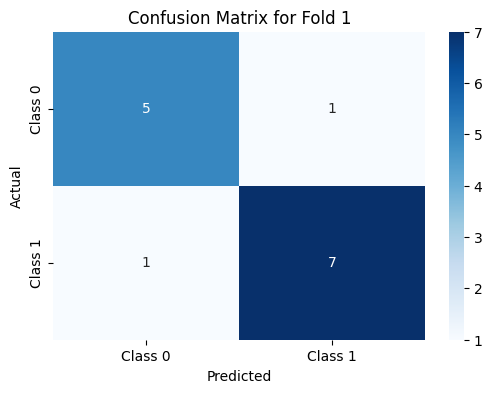

Evaluating Fold 2/5


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 2 Results:
Optimal Threshold: 0.7000
Accuracy: 0.9286
Precision: 0.8889
Recall: 1.0000
F1 Score: 0.9412


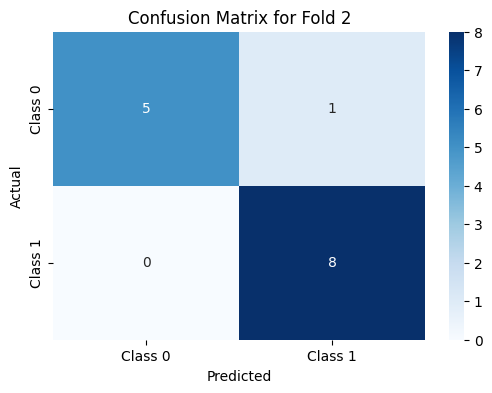

Evaluating Fold 3/5


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 3 Results:
Optimal Threshold: 0.6466
Accuracy: 0.8571
Precision: 0.8000
Recall: 1.0000
F1 Score: 0.8889


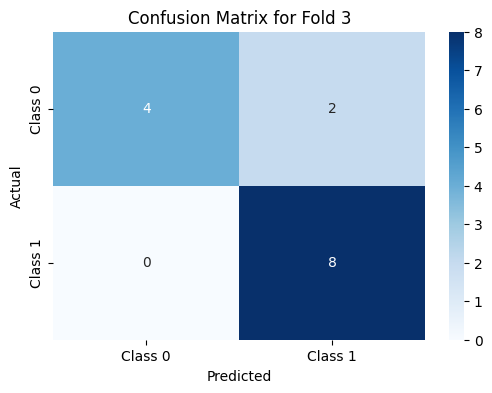

Evaluating Fold 4/5


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 4 Results:
Optimal Threshold: 0.6608
Accuracy: 0.7143
Precision: 0.6667
Recall: 1.0000
F1 Score: 0.8000


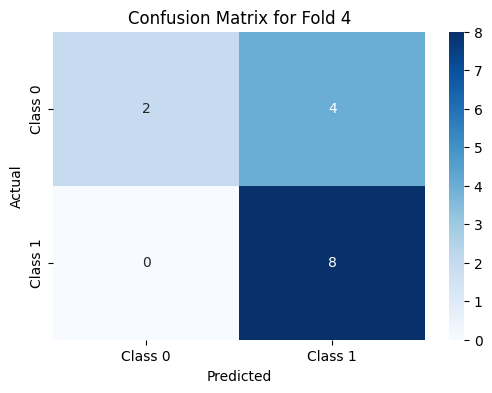

Evaluating Fold 5/5


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 5 Results:
Optimal Threshold: 0.6681
Accuracy: 0.8571
Precision: 1.0000
Recall: 0.7500
F1 Score: 0.8571


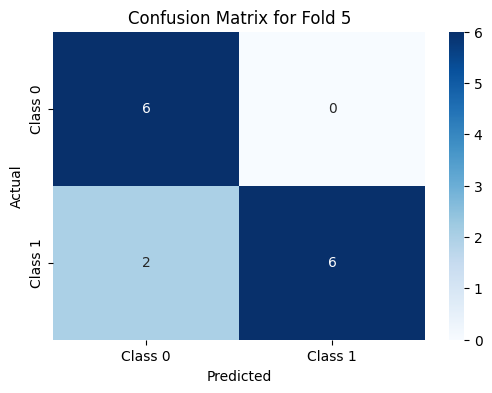

In [41]:
# Loop over each fold, evaluate performance, and display metrics
kmodel = SequentialTGNN(input_dim=768, hidden_dim=hyperparams['hidden_size'], output_dim=1)  
for i in range(5):
    print(f"Evaluating Fold {i + 1}/5")

    # Load model for this fold


    kmodel.load_state_dict(torch.load(f'models/best_model_fold_{i+1}.pt'))

    # Prepare test data loader (assuming `data_test` is available)
    test_loader = DataLoader(data_test, batch_size=1, shuffle=False)

    # Evaluate the model
    accuracy, precision, recall, f1, preds, all_labels, optimal_threshold = evaluate_model(kmodel, test_loader)

    # Print metrics
    print(f"Fold {i + 1} Results:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Fold {i + 1}')
    plt.show()
